## 0.2 - Developing initial algorithms

This notebook concerns the development of initial simple algorithms:
- Assigning all baths of the first request
- Assigning a new request after a given request has already been assigned


In [9]:
%load_ext autoreload
%autoreload 2

from src import ps
import numpy as np

In [101]:
ss = ps.Schedule()
ss.load_data(8) 

### 0.2.1 - First assignment

Given a request's index, the first_assignment() function assigns all baths of that request as the first one and returns:
- *tb*: the instants when the bath i starts 
- *ts*: the instants when the request enters the drying step h
- *tf*: the instant when the request leaves the last bath

It builds a schedule where the time of each bath and drying step is the minimum amount possible.

In [231]:
def first_assignment(index):
    
    _tb = np.zeros(shape=(ss.M))
    _ts = np.zeros(shape=(ss.H))
    _tin = np.array(ss.tin[index])
    _sec = np.array(ss.sec[index])
    
    # 1st cycle - assigning the baths taking into account the minimum amount of time required
    for j in range(1, ss.M):
        if j == 0:
            _tb[0] = 0
        
        else:
            _tb[j] = _tb[j - 1] + _tin[j - 1]
            
    # 2nd cycle - adding the drying steps     
    for h, j in enumerate(ss.b):
        _ts[h] = _tb[j]
        _tb[j:] += _sec[ss.b.index(j)]
    
    _tf = _tb[ss.M - 1] + _tin[ss.M - 1]
    
    return _tb, _ts, _tf

In [35]:
tb0, ts0, tf0 = first_assignment(0)

In [36]:
print("tb: %s" %tb0)
print("ts: %s" %ts0)
print("tf: %s" %tf0)

tb: [  0.  38. 127. 241. 290. 374. 523. 730. 817.]
ts: [197. 407. 623. 739.]
tf: 845.0


**Testing the performance** 

In [37]:
%timeit first_assignment(0)

92.3 µs ± 5.54 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [38]:
%%timeit

index = 0
_tb = np.zeros(shape=(ss.M))
_ts = np.zeros(shape=(ss.H))
_tin = np.array(ss.tin[index])
_sec = np.array(ss.sec[index])

16.2 µs ± 2.01 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [39]:
%%timeit

index = 0
_tb = [0 for _ in range(ss.M)]
_ts = [0 for _ in range(ss.H)]
_tin = ss.tin[index]
_sec = ss.sec[index]

4.87 µs ± 325 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


A gain in performance is seen if Python lists are used but then, the following assignment could not be done in the same way using lists. 

     _tb[j:] += _sec[ss.b.index(j)]
     
So, for now the numpy.array structure will be used in this function.

### 0.2.2 - Assigning a new request

This is one of the problem's main functions. Given an already scheduled request (whose times are defined by the arguments *tb_prev, ts_prev, tf_prev*), it assigns a new request with a given *index*.

The first version of this function worked in three cycles - three *for-loops*. Thus, it is very costly performance-wise. An explanation of the algorithm can be found in *References\Algoritmo - Nuevo pedido.pdf* (written in Spanish).

In [98]:
# 1st version
def assign_new_request(tb_prev, ts_prev, tf_prev, index):
    global M, sec, tin, tax
    
    _tb = np.zeros(shape=(ss.M))
    _ts = np.zeros(shape=(ss.H))
    _tin = np.array(ss.tin[index])
    _sec = np.array(ss.sec[index])
    _tax = np.array(ss.tax[index])
    _b = np.array(ss.b)
    
    # 1st cycle - assigning the baths taking into account minimum amount of time required
    # and the leaving time of the previous request
    
    for j in range(ss.M):
        
        if j == 0:
            _tb[0] = tb_prev[1]
        
        elif j < ss.M - 1:
            _tb[j] = max(_tb[j - 1] + _tin[j - 1], tb_prev[j+1])
        else:
            _tb[j] = max(_tb[j - 1] + _tin[j - 1], tf_prev)
    
    # 2nd cycle - adding the drying steps
    
    for h, j in enumerate(ss.b):
        j -= 1
        
        if j == 0:
            _tb[j:] -= _tb[j] - ts_prev[h]
        elif h > 0:
            _tb[j:] -= min(_tb[j] - (_tb[j - 1] + _tin[j - 1]), _tb[j] - ts_prev[h], _tb[j] - _ts[h - 1] - _sec[h - 1])
        else:
            _tb[j:] -= min(_tb[j] - (_tb[j - 1] + _tin[j - 1]), _tb[j] - ts_prev[h])
            
        _ts[h] = _tb[j] + _tin[j]
        delta = tb_prev[j + 1:] - _tb[j:-1]

        if j + 1 in ss.b:  
            _tb[j + 1:] += max(_sec[h], _sec[h] + ts_prev[ss.b.index(j + 1)] - _tb[j + 1], *delta)
        else:
            _tb[j + 1:] += max(_sec[h], _sec[h] + tb_prev[j + 2] - _tb[j + 1], *delta)
   
    _tf = _tb[ss.M - 1] + _tin[ss.M - 1]
    
    
    # 3rd cycle - correcting the baths whose times are greater than the maximum amount
    
    for j in range(ss.M):

        if j + 1 in ss.b:
            h = ss.b.index(j + 1)

            if _ts[h] > _tax[j] + _tb[j]:
                shift = _ts[h] - _tb[j] - _tax[j]
                _tb[:j + 1] += shift
                _ts[h] += shift

        elif j < ss.M - 1 and _tb[j + 1] > _tax[j] + _tb[j]:
            shift = _tb[j + 1] - _tb[j] - _tax[j]
            _tb[:j + 1] += shift
            _ts[_b < j + 1] += shift

        elif j == ss.M - 1 and tf_prev > _tb[j]:
            shift = tf_prev - _tb[j]
            _tb += shift
            _ts += shift
            _tf += shift
                
    return _tb, _ts, _tf
            

In [41]:
%timeit assign_new_request(tb0, ts0, tf0, index=1)

500 µs ± 52.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Again, a better performance could be achieved by building and algorithm with just one loop.
Besides that, after some experimentation, it was clear that the way of thinking about the requests' scheduling should be changed. The next steps will illustrate the problem.

In [223]:
tb0, ts0, tf0 = first_assignment(0)
tb17, ts17, tf17 = assign_new_request(tb0, ts0, tf0, 17)

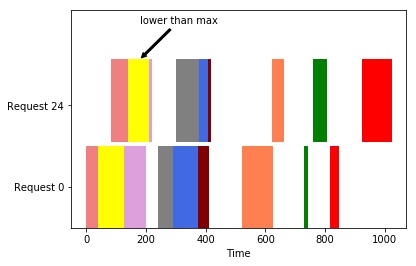

In [226]:
import matplotlib.pyplot as plt
co = ['lightcoral', 'yellow', 'plum', 'grey', 'royalblue', 'maroon', 'coral', 'g', 'red', 'sienna']

fig, ax = plt.subplots()
ax.set_xlabel('Time')
ax.set_yticks([1.5, 4.5])
ax.set_yticklabels(['Request 0', 'Request 17'])

ax.broken_barh(ss.compute_Vb(tb0, ts0, tf0), yrange=(0,3), color=co)
ax.broken_barh(ss.compute_Vb(tb23, ts23, tf23), yrange=(3.2,3), color=co)

ax.annotate('lower than max', 
            (180,6.2), 
            xytext=(180,7.5), 
            arrowprops=dict(facecolor='black', arrowstyle='simple'))
ax.set_ylim(0,8);

[a] The goal should not be to always have the smallest time in bath. In this example, if the sixth bath of the second request (Request 17) started sooner, the previous baths could also finish sooner and be available for the next request sooner.

### 0.2.3 - New algorithm for assigning a new request

This new algorithm is based on the previous algorithm, but it accomplishes the same of  with just one loop and taking into account the change proposed in [a].

In [220]:
# 2nd version

def assign_new_request_v2(tb_prev, ts_prev, tf_prev, index):

    _tb = np.zeros(shape=(ss.M))
    _ts = np.zeros(shape=(ss.H))
    _tin = np.array(ss.tin[index])
    _sec = np.array(ss.sec[index])
    _tax = np.array(ss.tax[index])
    _b = np.array(ss.b)

    _h = -1
    _jh = 0

    for j in range(ss.M):

        if j == 0:

            if j + 1 in ss.b:
                _tb[0] = ts_prev[0]
                _ts[0] = _tb[0] + _tin[0]
                _h = 0
                _jh = 1

            else:
                _tb[0] = tb_prev[1]

        elif j < ss.M - 1:

            if j in ss.b:
                _jh = j

                if j + 1 in ss.b:
                    _h += 1
                    _tb[j] = max(_ts[_h - 1] + _sec[_h - 1], ts_prev[_h])

                    _ts[_h] = _tb[j] + _tin[j]

                else:
                    _tb[j] = max(_ts[_h] + _sec[_h], tb_prev[j+1])

            else:

                if j + 1 in ss.b:
                    _h += 1
                    _tb[j] = max(_tb[j - 1] + _tin[j - 1], ts_prev[_h])
                    _ts[_h] = _tb[j] + _tin[j]

                else:
                    _tb[j] = max(_tb[j - 1] + _tin[j - 1], tb_prev[j+1])
                
                
                if _tb[j] - _tb[j - 1] > _tax[j - 1]:
                    #sub-algorithm used for correcting the problem addressed in [a]
                    
                    dif = _tb[j] - _tb[j - 1] - _tax[j - 1]
    
                    for k in reversed(range(_jh,j)):
                        if k in ss.b or k == 0:
                            _tb[k:j] += dif
                            break

                        else:
                            shift = -_tb[k] + _tb[k - 1] + _tax[k - 1]
                            _tb[k:j] += min(dif, shift)
                            dif -= shift

                            if dif <= 0:
                                break


        else:

            if j in ss.b:
                _tb[j] = max(_ts[_h] + _sec[_h], tf_prev)

            else:
                _tb[j] = max(_tb[j - 1] + _tin[j - 1], tf_prev)

                if _tb[j] - _tb[j - 1] > _tax[j - 1]:
                    _tb[_jh:j] += _tb[j] - _tb[j - 1] - _tax[j - 1]

                    dif = _tb[j] - _tb[j - 1] - _tax[j - 1]
                    
                    for k in reversed(range(_jh,j)):

                        if k in ss.b or k == 0:
                            _tb[k:j] += dif
                            break

                        else:
                            shift = -_tb[k] + _tb[k - 1] + _tax[k - 1]
                            _tb[k:j] += min(dif, shift)
                            dif -= shift

                            if dif <= 0:
                                break


    _tf = _tb[ss.M - 1] + _tin[ss.M - 1]

    return _tb, _ts, _tf

In [228]:
tb23_2, ts23_2, tf23_2 = assign_new_request_v2(tb0, ts0, tf0, 17)

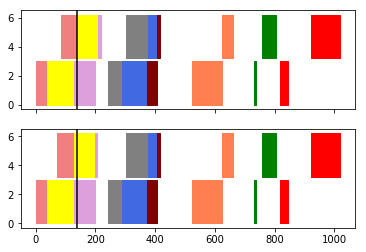

In [229]:
fig, ax = plt.subplots(nrows=2, sharex=True)

ax[0].broken_barh(ss.compute_Vb(tb0, ts0, tf0), yrange=(0,3), color=co)
ax[0].broken_barh(ss.compute_Vb(tb23, ts23, tf23), yrange=(3.2,3), color=co);

ax[1].broken_barh(ss.compute_Vb(tb0, ts0, tf0), yrange=(0,3), color=co)
ax[1].broken_barh(ss.compute_Vb(tb23_2, ts23_2, tf23_2), yrange=(3.2,3), color=co);

ax[1].axvline(x=tb30[1], color='black')
ax[0].axvline(x=tb30[1], color='black');

This new algorithm assigns longer baths when it is needed. In the figure, the second bath of the second request is shifted to left in the graph below (corresponding to the nem algorithm). This means that the second bath of the next request can start sooner.

In [230]:
%timeit assign_new_request_v2(tb0, ts0, tf0, index=1)

121 µs ± 9.51 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
